In [1]:
%matplotlib inline

import numpy as np
import rasterio
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
from __future__ import division
import pandas as pd
import seaborn
from rasterstats import zonal_stats


## Configure 

In [2]:
# Specify the residuals datasets to read in
year='2017'
stable='reanalysis'

# List of buffer distances (must have corresponding shapefiles)
dists = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

# Add 'km' for field naming and display
dists_l = [str(dist) + 'km' for dist in dists]


## Read in residuals and NLCD datasets

In [3]:
# Read in residual maps

# Handle new file naming convention for 2018  
if year == '2018':
    residuals_m_fn = '../../reanalysis/{year}_reanalysis/final_products/{year}_{stable}_meanresiduals_forestmask_all_GS.tif'.format(year=year, stable=stable)
    residuals_fn = '../../reanalysis/{year}_reanalysis/final_products/{year}_{stable}_meanresiduals_all_GS.tif'.format(year=year, stable=stable)
else:
    residuals_m_fn = '../../reanalysis/{year}_reanalysis/final_products/{year}_{stable}_meanresiduals_forestmask.tif'.format(year=year, stable=stable)
    residuals_fn = '../../reanalysis/{year}_reanalysis/final_products/{year}_{stable}_meanresiduals.tif'.format(year=year, stable=stable)

# Read in full residuals dataset
print(residuals_fn)
with rasterio.open(residuals_fn) as image:
    residuals = image.read(1)
print(residuals.shape)
# Reassign nodata value (use positive 9999 so we can mask all positive values)
residuals[residuals == -9999] = 9999

# Read in masked residuals dataset
print(residuals_m_fn)
with rasterio.open(residuals_m_fn) as image:
    residuals_m = image.read(1)
print(residuals_m.shape)
# Reassign nodata value (use positive 9999 so we can mask all positive values)
residuals_m[residuals_m == -9999] = 9999

../../reanalysis/2017_reanalysis/final_products/2017_reanalysis_meanresiduals.tif
(15155, 16917)
../../reanalysis/2017_reanalysis/final_products/2017_reanalysis_meanresiduals_forestmask.tif
(15155, 16917)


In [4]:
# Read in NLCD to use for forest pixel counts
NLCD_fn = '/projectnb/landsat/projects/Massachusetts/defoliators/reanalysis/NLCD_mask/NLCD_forest_mask.tif'
with rasterio.open(NLCD_fn) as image:
    NLCD = image.read(1)
print(NLCD.shape)
NLCD[NLCD == -9999] = 0
print(np.unique(NLCD))

(15155, 16917)
[0 1]


## Create threshold maps and calculate percent defoliated within each buffer

In [5]:
# Create binary map for different thresholds
in_ds = gdal.Open(residuals_fn, gdal.GA_ReadOnly)

# List of thresholds for residual groupings
thresholds = [-1, -2, -3, -4]
for threshold in thresholds:
    print('Calculating...')
    print(threshold)
    residuals_thresh = (residuals <= threshold).astype(int)
    residuals_thresh_m = (residuals_m <= threshold).astype(int)
    
    # Write output to raster (full)
    output_fn = '../../_elk_plots/threshold/{year}_threshold_{threshold}.tif'.format(year=year, threshold=threshold)
    out_driver = gdal.GetDriverByName("GTiff")
    out_ds = out_driver.Create(output_fn, 
                               residuals.shape[1],  # x size
                               residuals.shape[0],  # y size
                               1,  # number of bands
                               gdal.GDT_Int32)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_ds.GetRasterBand(1).WriteArray(residuals_thresh)
    out_ds = None
    
    # Write output to raster (forest masked)
    output_m_fn = '../../_elk_plots/threshold/{year}_threshold_{threshold}_forestmask.tif'.format(year=year, threshold=threshold)
    out_driver = gdal.GetDriverByName("GTiff")
    out_ds = out_driver.Create(output_m_fn, 
                               residuals.shape[1],  # x size
                               residuals.shape[0],  # y size
                               1,  # number of bands
                               gdal.GDT_Int32)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_ds.GetRasterBand(1).WriteArray(residuals_thresh_m)
    out_ds = None
    
    # Initialize dataframes for storing results
    df_all = pd.DataFrame()
    df_for = pd.DataFrame()

    # Loop over distances and extract raster count and sum based on buffer shapefiles
    for dist_l in dists_l:
        vector = '/projectnb/landsat/projects/Massachusetts/defoliators/_elk_plots/GIS/elkplots_v3/moth_plots_{dist_l}.shp'.format(dist_l=dist_l)
        
        # Calculate summary stats for ALL pixels
        stats = zonal_stats(vector, output_fn, nodata=-9999, stats=['count','sum'], geojson_out=True)
        zonal = pd.DataFrame(stats)
        
        # Calculate summary stats for only FORESTED pixels
        stats_m = zonal_stats(vector, output_m_fn, nodata=-9999, stats=['count','sum'], geojson_out=True)
        zonal_m = pd.DataFrame(stats_m)
        
        # Calculate number of FORESTED pixels using NLCD
        stats_NLCD = zonal_stats(vector, NLCD_fn, nodata=-9999, stats=['count','sum'], geojson_out=True)
        zonal_NLCD = pd.DataFrame(stats_NLCD)
        
        # Add ID field to dataframes
        key_list = zonal['properties'].keys()
        df_all['ID'] = key_list
        df_for['ID'] = key_list
        
        # Add city information to dataframes
        for i, key in enumerate(key_list):
            df_all.loc[key, 'CITY'] = zonal['properties'][key]['CITY']
            df_for.loc[key, 'CITY'] = zonal['properties'][key]['CITY']
        
        # Compute SUM and COUNT then use to calculate PERCENT DEFOLIATION within each buffer zone
        # Loop over sites
        for i, key in enumerate(key_list):
            # Calculate total number of FORESTED pixels at threshold / total area within buffer
            df_all.loc[key, 'sum_{dist}'.format(dist=dist_l)] = zonal_m['properties'][key]['sum']
            df_all.loc[key, 'count_{dist}'.format(dist=dist_l)] =  zonal['properties'][key]['count']
            if zonal['properties'][key]['count'] > 0:
                df_all.loc[key, 'perc_{dist}'.format(dist=dist_l)] =  (zonal_m['properties'][key]['sum'] / zonal['properties'][key]['count'])*100
            
            # Calculate total number of FORESTED pixels at threshold / total FORESTED area
            df_for.loc[key, 'sumfor_{dist}'.format(dist=dist_l)] =  zonal_m['properties'][key]['sum']
            df_for.loc[key, 'countfor_{dist}'.format(dist=dist_l)] =  zonal_NLCD['properties'][key]['sum']
            if zonal_NLCD['properties'][key]['count'] > 0:
                df_for.loc[key, 'percfor_{dist}'.format(dist=dist_l)] = (zonal_m['properties'][key]['sum'] / zonal_NLCD['properties'][key]['count'])*100
        
        # Write dataframes to CSV
        # Outputs one CSV per threshold per year
        df_all.to_csv('../../_elk_plots/GIS/elkplots_v3/stats_all_{threshold}_{year}.csv'.format(threshold=threshold, year=year))
        df_for.to_csv('../../_elk_plots/GIS/elkplots_v3/stats_forest_{threshold}_{year}.csv'.format(threshold=threshold, year=year))

Calculating...
-1
Calculating...
-2
Calculating...
-3
Calculating...
-4


In [6]:
# Drop NA values
df_all.dropna(inplace=True)
df_for.dropna(inplace=True)

## Generate semivariogram plots

In [7]:
dataset = 'forest'

In [8]:
stats_1 = pd.read_csv('../../_elk_plots//GIS/elkplots_v3/stats_{dataset}_-1_{year}.csv'.format(dataset=dataset, year=year))
stats_2 = pd.read_csv('../../_elk_plots/GIS/elkplots_v3/stats_{dataset}_-2_{year}.csv'.format(dataset=dataset, year=year))
stats_3 = pd.read_csv('../../_elk_plots/GIS/elkplots_v3/stats_{dataset}_-3_{year}.csv'.format(dataset=dataset, year=year))
stats_4 = pd.read_csv('../../_elk_plots/GIS/elkplots_v3/stats_{dataset}_-4_{year}.csv'.format(dataset=dataset, year=year))

In [9]:
if dataset == 'forest':
    fields = ['percfor_' + dist_l for dist_l in dists_l]
else:
    fields = ['perc_' + dist_l for dist_l in dists_l]

stats_1_arr = np.asarray(stats_1[fields])
stats_2_arr = np.asarray(stats_2[fields])
stats_3_arr = np.asarray(stats_3[fields])
stats_4_arr = np.asarray(stats_4[fields])


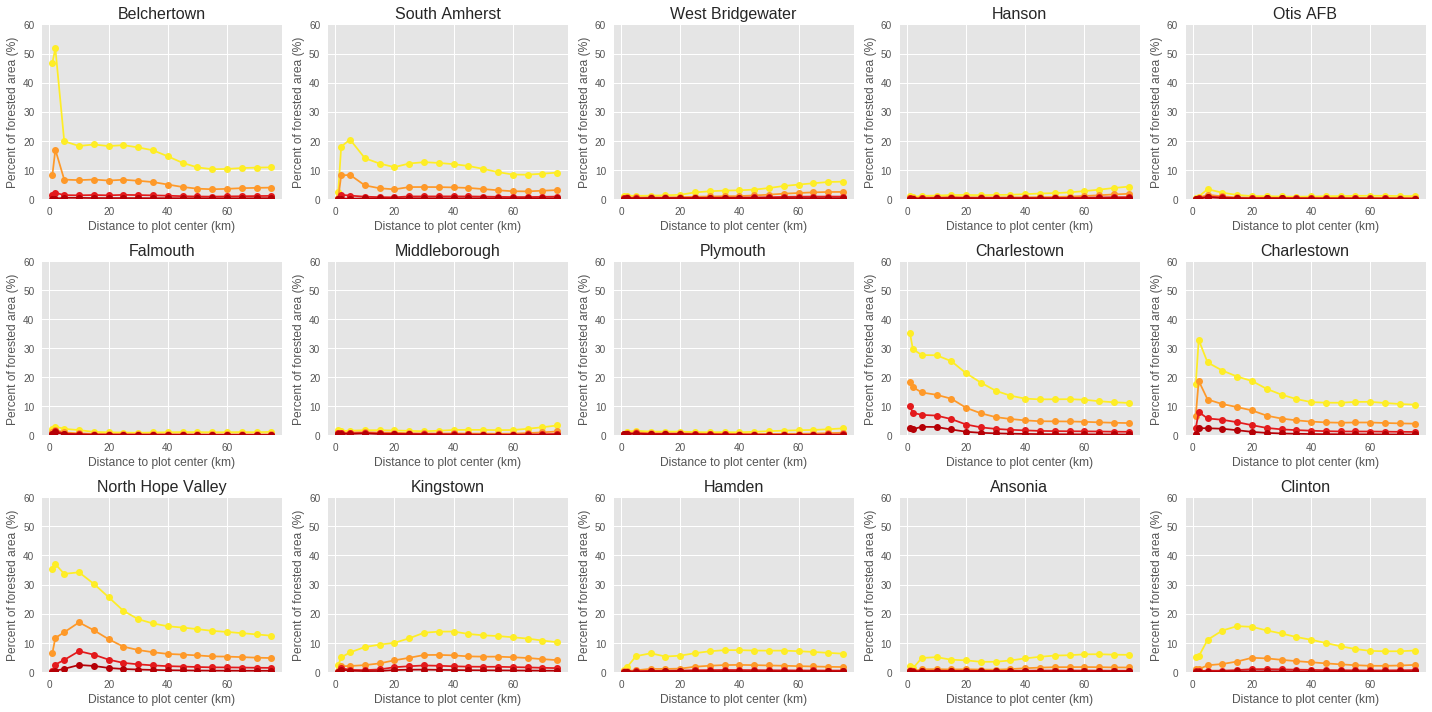

In [10]:
# Plot for all sites
sites = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

fig = plt.figure(figsize=(20,10))
plt.style.use('ggplot') 
for site in sites:
    town = stats_1['CITY'][site]
    ax = fig.add_subplot(3,5,(site+1))
    plt.plot(dists, stats_1_arr[site], marker='o', color="#feed26")
    plt.plot(dists, stats_2_arr[site], marker='o', color="#fe9929")
    plt.plot(dists, stats_3_arr[site], marker='o', color="#e31a1c")
    plt.plot(dists, stats_4_arr[site], marker='o', color="#b50006")
    plt.title('{town}'.format(town=town), fontsize=16)
    if dataset == 'forest':
        plt.ylabel('Percent of forested area (%)')
    else: 
        plt.ylabel('Percent of total area (%)')
    plt.ylim((0,60))
    plt.xlabel('Distance to plot center (km)')

plt.tight_layout()
if dataset == 'forest':
    plt.savefig('../../_elk_plots/GIS/elkplots_v3/plot_semivar_forest_{year}.png'.format(year=year), dpi=400)
else: 
    plt.savefig('../../_elk_plots/GIS/elkplots_v3/plot_semivar_all_{year}.png'.format(year=year), dpi=400)     
plt.show()

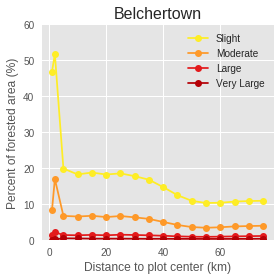

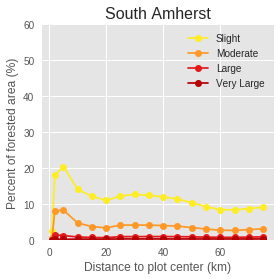

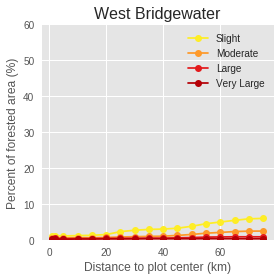

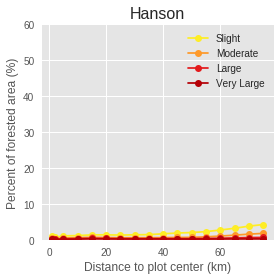

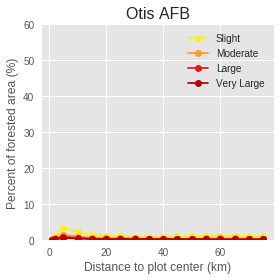

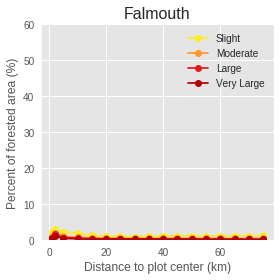

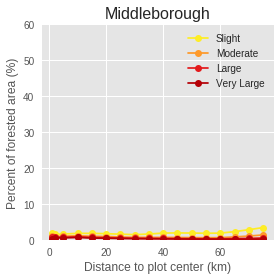

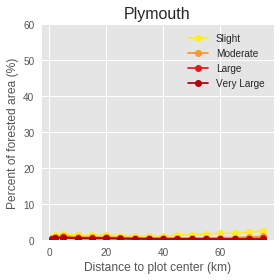

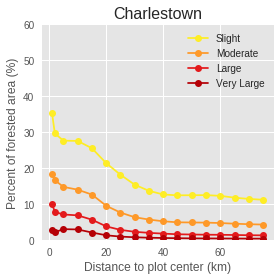

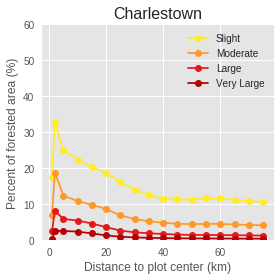

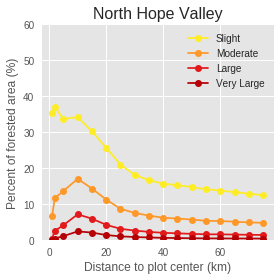

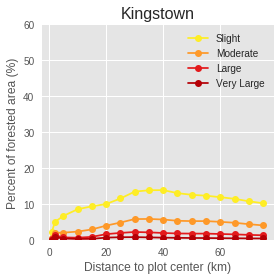

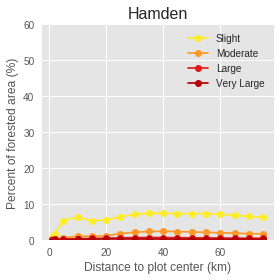

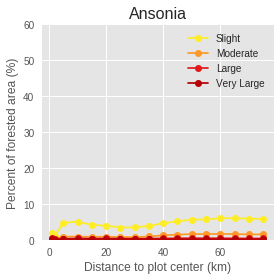

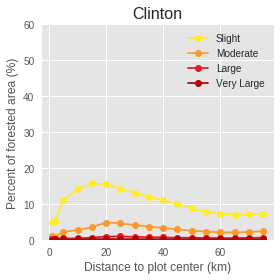

In [11]:
# Separate plot for each site
plt.style.use('ggplot') 
for site in sites:
    town = stats_1['CITY'][site]
    fig = plt.figure(figsize=(4,4))
    plt.plot(dists, stats_1_arr[site], marker='o', color="#feed26", label='Slight')
    plt.plot(dists, stats_2_arr[site], marker='o', color="#fe9929", label='Moderate')
    plt.plot(dists, stats_3_arr[site], marker='o', color="#e31a1c", label='Large')
    plt.plot(dists, stats_4_arr[site], marker='o', color="#b50006", label='Very Large')
    plt.title('{town}'.format(town=town), fontsize=16)
    if dataset == 'forest':
        plt.ylabel('Percent of forested area (%)')
    else: 
        plt.ylabel('Percent of total area (%)')
    plt.ylim((0,60))
    plt.xlabel('Distance to plot center (km)')
    
    plt.legend()

    plt.tight_layout()
    
    if dataset == 'forest':
        plt.savefig('../../_elk_plots/GIS/elkplots_v3/plot_semivar_forest_{year}_{town}.png'.format(year=year,town=town), dpi=400)
    else: 
        plt.savefig('../../_elk_plots/GIS/elkplots_v3/plot_semivar_all_{year}_{town}.png'.format(year=year,town=town), dpi=400)  
    plt.show()
